In [2]:
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt

In [3]:
path = 'D:/'

In [63]:
df = pd.read_csv('{}US1.AAPL_160101_210101.txt'.format(path))
df.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.AAPL,30,20160104,180000,102.6100,103.690,102.000,102.6923,9305131
1,US1.AAPL,30,20160104,183000,102.6800,103.590,102.380,103.2800,4822555
2,US1.AAPL,30,20160104,190000,103.2861,103.935,103.010,103.3420,3886702
3,US1.AAPL,30,20160104,193000,103.3300,103.470,102.500,103.4241,3235895
4,US1.AAPL,30,20160104,200000,103.4200,103.900,103.205,103.8300,2501232


<AxesSubplot:xlabel='<DATE>'>

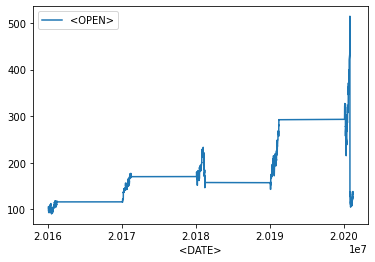

In [64]:
df.plot(x="<DATE>", y="<OPEN>")
                                

<AxesSubplot:xlabel='<DATE>'>

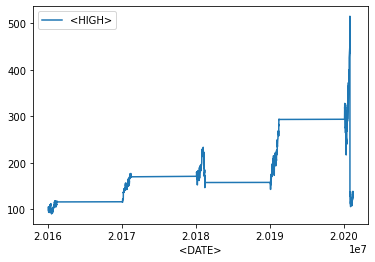

In [65]:
df.plot(x="<DATE>", y="<HIGH>")

In [66]:
df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>']].corr()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>
<OPEN>,1.000000,0.999963,0.999962,0.999942
<HIGH>,0.999963,1.000000,0.999930,0.999968
<LOW>,0.999962,0.999930,1.000000,0.999962
<CLOSE>,0.999942,0.999968,0.999962,1.000000


In [71]:
df_ml = df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>']]

train_size = int(df.shape[0] * 0.6)
train = df_ml.iloc[:train_size]
tmp = df_ml.iloc[train_size:]
test = tmp.iloc[int(tmp.shape[0] * 0.3):]
val = tmp.iloc[:int(tmp.shape[0] * 0.3)]

In [72]:
train.shape, val.shape, test.shape

((9805, 4), (1961, 4), (4576, 4))

In [79]:
scaler = StandardScaler()
train_arr = train.copy()
val_arr = val.copy()
test_arr = test.copy()
for i in range(len(df_ml.columns)):
    train_arr.iloc[:, i] = scaler.fit_transform(train.iloc[:, i].values.reshape(-1,1))
    val_arr.iloc[:, i] = scaler.fit_transform(val.iloc[:, i].values.reshape(-1,1))
    test_arr.iloc[:, i] = scaler.fit_transform(test.iloc[:, i].values.reshape(-1,1))

In [29]:
import torch
from torch.autograd import Variable

In [80]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var
seq_len = 100
x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test,y_test = transform_data(test_arr, seq_len)

In [31]:
import torch.nn as nn
import torch.optim as optim
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    def forward(self, input, future=0, y=None):
        outputs = []        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]       
            for i in range(future):
                if y is not None and random.random() > 0.5:
                    output = y[:, [i]]  # teacher forcing
                    h_t, c_t = self.lstm(output, (h_t, c_t))
                    output = self.linear(h_t)
                    outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [44]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [33]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [34]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

In [81]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [82]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

Epoch 1 Train loss: 0.20. Validation loss: 0.38. Avg future: 0.00. Elapsed time: 26.92s.
Epoch 2 Train loss: 0.09. Validation loss: 0.23. Avg future: 0.00. Elapsed time: 28.61s.
Epoch 3 Train loss: 0.07. Validation loss: 0.15. Avg future: 0.00. Elapsed time: 29.80s.
Epoch 4 Train loss: 0.04. Validation loss: 0.09. Avg future: 0.00. Elapsed time: 29.02s.
Epoch 5 Train loss: 0.03. Validation loss: 0.07. Avg future: 0.00. Elapsed time: 30.81s.
Epoch 6 Train loss: 0.03. Validation loss: 0.04. Avg future: 0.00. Elapsed time: 42.24s.
Epoch 7 Train loss: 0.01. Validation loss: 0.04. Avg future: 0.00. Elapsed time: 31.16s.
Epoch 8 Train loss: 0.01. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 24.87s.
Epoch 9 Train loss: 0.01. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 25.98s.
Epoch 10 Train loss: 0.01. Validation loss: 0.02. Avg future: 0.00. Elapsed time: 28.40s.
Epoch 11 Train loss: 0.01. Validation loss: 0.02. Avg future: 0.00. Elapsed time: 27.57s.
Epoch 12 Train loss

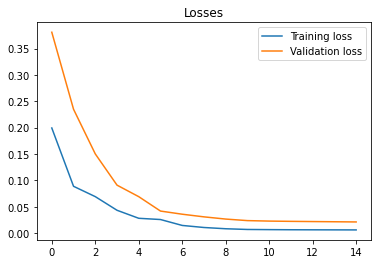

In [83]:
optimization_1.plot_losses()

Test loss 0.0122


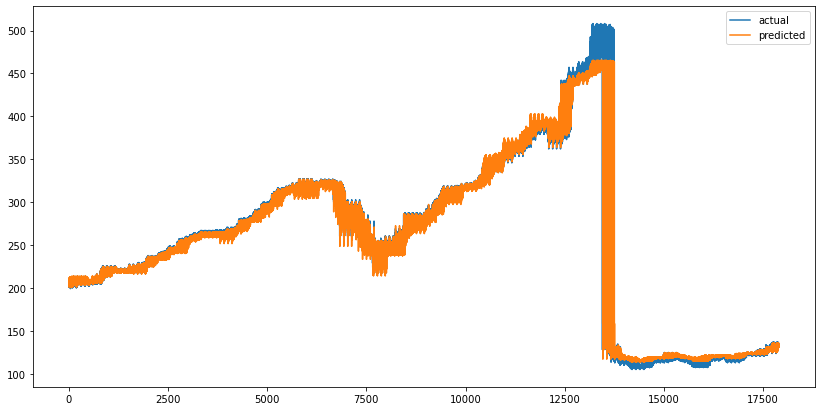

In [86]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)